In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
csv = 'clean_tweets.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\Rushi\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,that bummer you shoulda got david carr of thir...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [3]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596064 entries, 0 to 1596063
Data columns (total 2 columns):
text      1596064 non-null object
target    1596064 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
#Training and Developing Model

In [5]:
x = my_df.text
y = my_df.target

In [6]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [7]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564142 entries with 50.01% negative, 49.99% positive
Validation set has total 15961 entries with 49.72% negative, 50.28% positive
Test set has total 15961 entries with 50.47% negative, 49.53% positive


In [8]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

Wall time: 2.61 s


In [10]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.32%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7198                 827
negative                5347                2589
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.76      0.33      0.46      7936
           1       0.57      0.90      0.70      8025

   micro avg       0.61      0.61      0.61     15961
   macro avg       0.67      0.61      0.58     15961
weighted avg       0.67      0.61      0.58     15961



In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [12]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [13]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [14]:
%%time
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features


C:\Users\Rushi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.28%
accuracy score: 76.93%
model is 26.65% more accurate than null accuracy
train and test time: 57.74s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.28%
accuracy score: 77.23%
model is 26.95% more accurate than null accuracy
train and test time: 66.82s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.28%
accuracy score: 77.46%
model is 27.19% more accurate than null accuracy
train and test time: 83.57s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.28%
accuracy score: 77.51%
model is 27.23% more accurate than null accuracy
train and test time: 83.47s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.28%
accuracy score: 77

In [15]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.28%
accuracy score: 79.29%
model is 29.01% more accurate than null accuracy
train and test time: 112.64s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.28%
accuracy score: 79.56%
model is 29.28% more accurate than null accuracy
train and test time: 150.32s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.28%
accuracy score: 79.75%
model is 29.47% more accurate than null accuracy
train and test time: 172.26s
--------------------------------------------------------

In [16]:
csv = 'term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313156,252561,565717
the,257867,265995,523862
my,190837,125979,316816
it,157478,147796,305274
and,153968,149642,303610
you,103886,198333,302219
not,194756,86870,281626
is,133440,111194,244634
in,115541,101157,216698
for,99003,117363,216366


In [17]:
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [18]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [19]:
%%time
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.28%
accuracy score: 78.22%
model is 27.94% more accurate than null accuracy
train and test time: 80.34s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.28%
accuracy score: 78.77%
model is 28.49% more accurate than null accuracy
train and test time: 98.85s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.28%
accuracy score: 78.94%
model is 28.66% more accurate than null accuracy
train and test time: 115.28s
------------------------

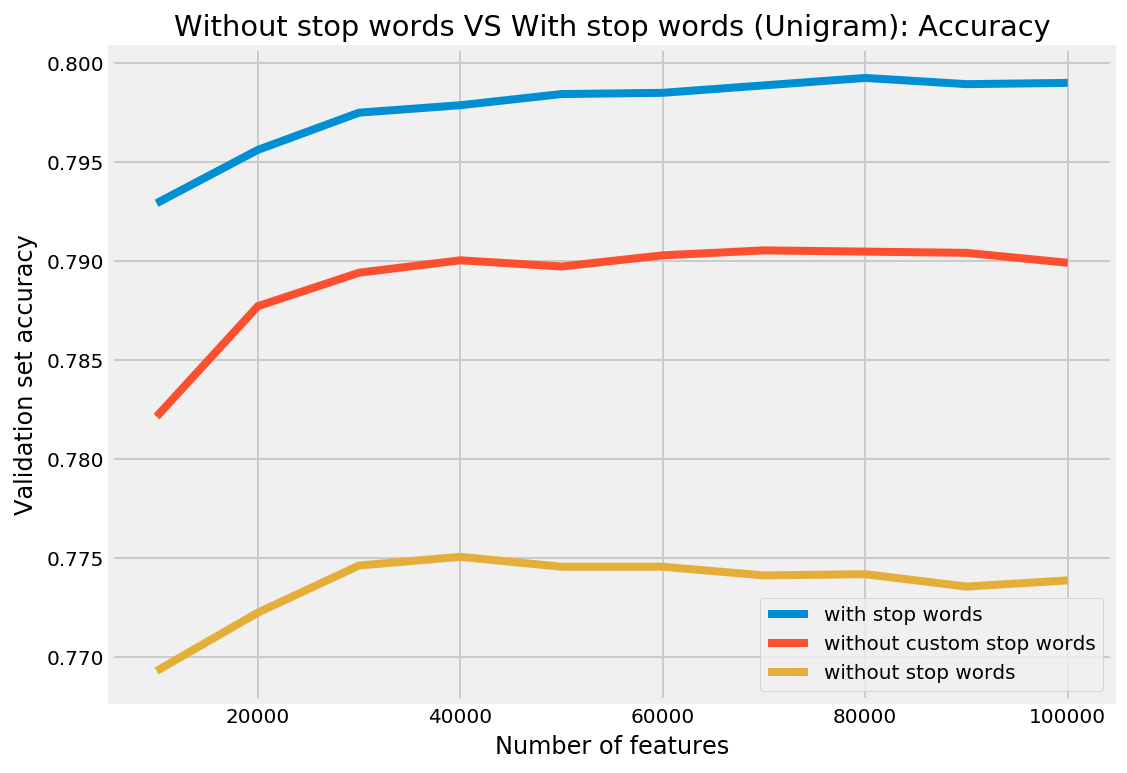

In [20]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [21]:
%%time
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.28%
accuracy score: 80.07%
model is 29.79% more accurate than null accuracy
train and test time: 183.98s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.28%
accuracy score: 81.06%
model is 30.78% more accurate than null accuracy
train and test time: 200.25s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.28%
accuracy score: 81.45%
model is 31.18% more accurate than null accuracy
train and test time: 172.07s
---------------------------------------------------------

In [22]:
%%time
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.28%
accuracy score: 80.10%
model is 29.82% more accurate than null accuracy
train and test time: 268.26s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.28%
accuracy score: 80.86%
model is 30.58% more accurate than null accuracy
train and test time: 277.95s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.28%
accuracy score: 81.42%
model is 31.14% more accurate than null accuracy
train and test time: 381.40s
--------------------------------------------------------

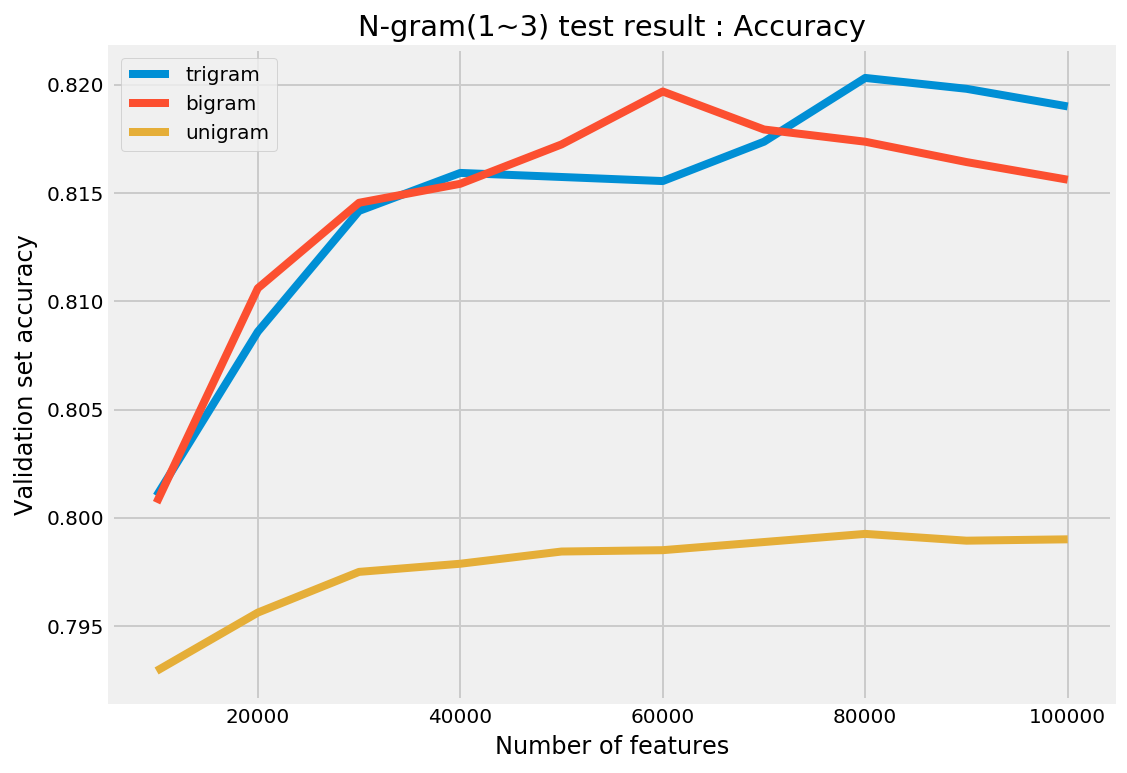

In [23]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [24]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

In [25]:
%%time
ug_cvec = CountVectorizer(max_features=80000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.28%
accuracy score: 79.93%
model is 29.65% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6270                1666
positive                1538                6487
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.80      0.79      0.80      7936
    positive       0.80      0.81      0.80      8025

   micro avg       0.80      0.80      0.80     15961
   macro avg       0.80      0.80      0.80     15961
weighted avg       0.80      0.80      0.80     15961

Wall time: 2min 53s


In [26]:
%%time
bg_cvec = CountVectorizer(max_features=70000,ngram_range=(1, 2))
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.28%
accuracy score: 81.79%
model is 31.51% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6360                1576
positive                1330                6695
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81      7936
    positive       0.81      0.83      0.82      8025

   micro avg       0.82      0.82      0.82     15961
   macro avg       0.82      0.82      0.82     15961
weighted avg       0.82      0.82      0.82     15961

Wall time: 3min 46s


In [27]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.28%
accuracy score: 82.03%
model is 31.75% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6391                1545
positive                1323                6702
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      7936
    positive       0.81      0.84      0.82      8025

   micro avg       0.82      0.82      0.82     15961
   macro avg       0.82      0.82      0.82     15961
weighted avg       0.82      0.82      0.82     15961

Wall time: 7min 8s
